In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import mat73
import neo
from elephant.statistics import instantaneous_rate
from elephant.kernels import GaussianKernel
from quantities import ms

from MARBLE import utils, plotting

from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
import jPCA

In [4]:
folder = '../outputs/spiking_data/'#'/media/robert/Extreme SSD/ResearchProjects/MARBLE/lfads-neural-stitching-reproduce/'
file = 'conditions_spiking_data.mat'
    
# load data compiled into matlab cell array
data = mat73.loadmat(folder+file)['all_results']

In [5]:
session=0
conditions = ['DownLeft','Left','UpLeft','Up','UpRight','Right','DownRight']

In [85]:
rates = {}
for c, cond in enumerate(conditions):
    trials = data[session][c]
    trial_data = []
    for trial in trials:
        if trial:
            trial = trial[0]
            inst_rates = []
            for ch in range(trial.shape[0]):
                        
                # extract spikes for a given channel (neuron)
                spikes = np.where(trial[ch,:])[0]
                        
                # get spike train (1200 milliseconds)
                st = neo.SpikeTrain(spikes, units='ms', t_stop=1200)
                        
                # get rates
                gk = GaussianKernel(100*ms) # increase this for smoother signals (previously used auto)
                # ek = ExponentialKernel(100*ms) # assymetric kernel and not smooth output
                sampling_period=1
                inst_rate = instantaneous_rate(st, kernel=gk, sampling_period=sampling_period*ms).magnitude
                inst_rate = inst_rate[500//sampling_period:]
                        
                # append into list
                inst_rates.append(inst_rate.flatten())
                    
            # stack rates back together and transpose = (channels by time)
            inst_rates = np.stack(inst_rates,axis=1)
            
            # append rates from one trial into trial data
            trial_data.append(inst_rates)
    
    # stack into an array of trial x channels x time
    rates[cond] = np.dstack(trial_data).transpose(2,0,1)

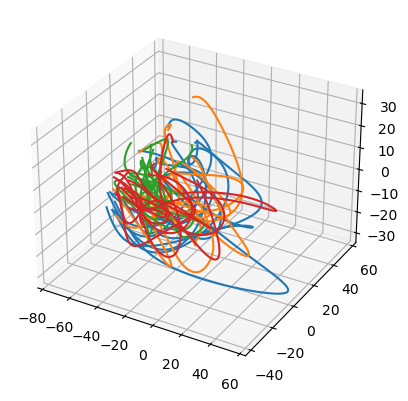

In [95]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pca = PCA(n_components=3)
pca.fit(np.vstack(all_rates))

for i,cond in enumerate(conditions[:4]):
    for t in rates[cond][:10]:
        t_pca = pca.transform(t)
        plt.plot(t_pca[:,0],t_pca[:,1],t_pca[:,2],'C{}'.format(i))